## Introduction to NLP
Natural Language Processing (NLP) is a field of artificial intelligence that focuses on the interaction between computers and humans through natural language. The goal is to enable computers to understand, interpret, and generate human language in a way that is both meaningful and useful.

### Key NLP Applications:

* **Text Classification**: Assigning predefined categories to text data.
* **Sentiment Analysis**: Determining the emotional tone behind words.
* **Machine Translation**: Translating text from one language to another.
* **Named Entity Recognition**: Identifying entities like names, places, dates in text.

## Installing Hugging Face's nlp package & Importing libraries

In [83]:
%matplotlib inline

import tensorflow as tf
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred):

    cm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)))
    plt.yticks(list(range(0, 6)))
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.17.0


## Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [10]:
# Importing the Tweet Emotion dataset
df_train = pd.read_csv('datasets/training.csv')
df_test = pd.read_csv('datasets/test.csv')
df_validation = pd.read_csv('datasets/validation.csv')

In [11]:
df_train.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [20]:
df_test['text'][0]

'im feeling rather rotten so im not very ambitious right now'

In [24]:
def get_tweet(data):
    tweets = data['text']
    labels = data['label']
    return tweets, labels

In [25]:
# type of columns
df_train.dtypes

text     object
label     int64
dtype: object

In [27]:
tweets, labels = get_tweet(df_train)

In [28]:
tweets[0], labels[0]

('i didnt feel humiliated', 0)

## Task 4: Tokenizer

1. Tokenizing the tweets

**Tokenization** is the process of breaking down text into smaller units called tokens, which can be words, characters, or subwords. Tokenization is crucial because it:

* Simplifies the text for processing.
* Helps in converting text to numerical data.
* Aids in handling different text formats and languages.

**TensorFlow's Tokenizer**

TensorFlow provides a Tokenizer class that:

* Converts text to sequences of integers.
* Creates a word index mapping words to numbers.
* Handles out-of-vocabulary words using an $OOV$ token.


In [29]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [30]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [31]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

## Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

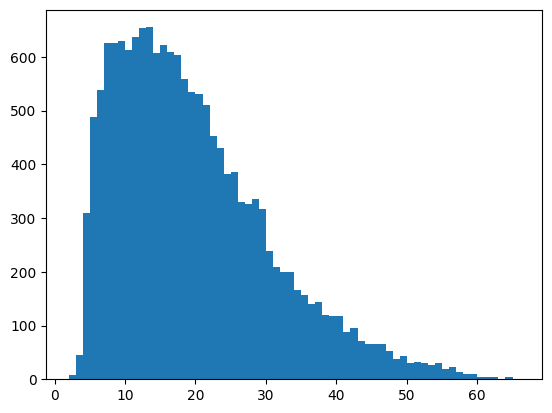

In [32]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [34]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [37]:
maxlen = 50
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
    return padded

In [38]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [45]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

(array([4666.,    0., 5362.,    0., 1304.,    0., 2159.,    0., 1937.,
           0.,  572.]),
 array([0.        , 0.45454545, 0.90909091, 1.36363636, 1.81818182,
        2.27272727, 2.72727273, 3.18181818, 3.63636364, 4.09090909,
        4.54545455, 5.        ]),
 <BarContainer object of 11 artists>)

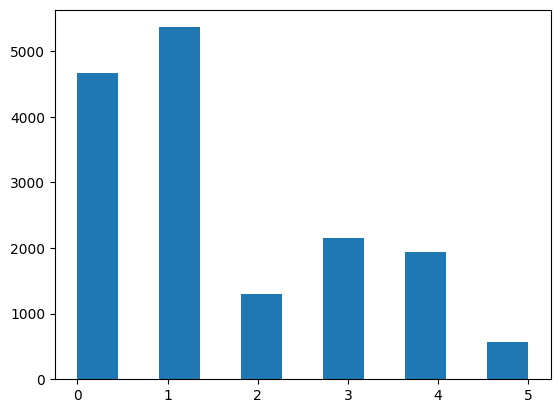

In [47]:
plt.hist(labels, bins=11)

## Creating the Model

1. Creating the model
2. Compiling the model


We'll build a Sequential model with the following layers:

* **Embedding Layer**: Maps each word to a vector of fixed size.
* **Bidirectional LSTM Layers**: Captures patterns in the text data.
* **Dense Layer**: Outputs probabilities for each emotion class.

In [53]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=16, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')    
])

model.build(input_shape=(None, maxlen))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

d:\anaconda\envs\venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [54]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 50, 16)         │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 50, 40)         │         5,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 40)             │         9,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           246 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 175,926 (687.21 KB)

 Trainable params: 175,926 (687.21 KB)

 Non-trainable params: 0 (0.00 B)

## Training the Model

1. Preparing a validation set
2. Training the model

In [55]:
val_tweets, val_labels = get_tweet(df_validation)
val_seq = get_sequences(tokenizer, val_tweets)

In [56]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [57]:
h = model.fit(
    padded_train_seq, labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.3803 - loss: 1.5347 - val_accuracy: 0.6195 - val_loss: 0.9942
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.7148 - loss: 0.7701 - val_accuracy: 0.8190 - val_loss: 0.5520
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8830 - loss: 0.3516 - val_accuracy: 0.8470 - val_loss: 0.4614
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9295 - loss: 0.2175 - val_accuracy: 0.8740 - val_loss: 0.4163
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9543 - loss: 0.1507 - val_accuracy: 0.8795 - val_loss: 0.3844
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9686 - loss: 0.1048 - val_accuracy: 0.8860 - val_loss: 0.3539
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9734 - loss: 0.0878 - val_accuracy: 0.8930 - val_loss: 0.3808
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9783 - loss: 0.0769 - val_a

## Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

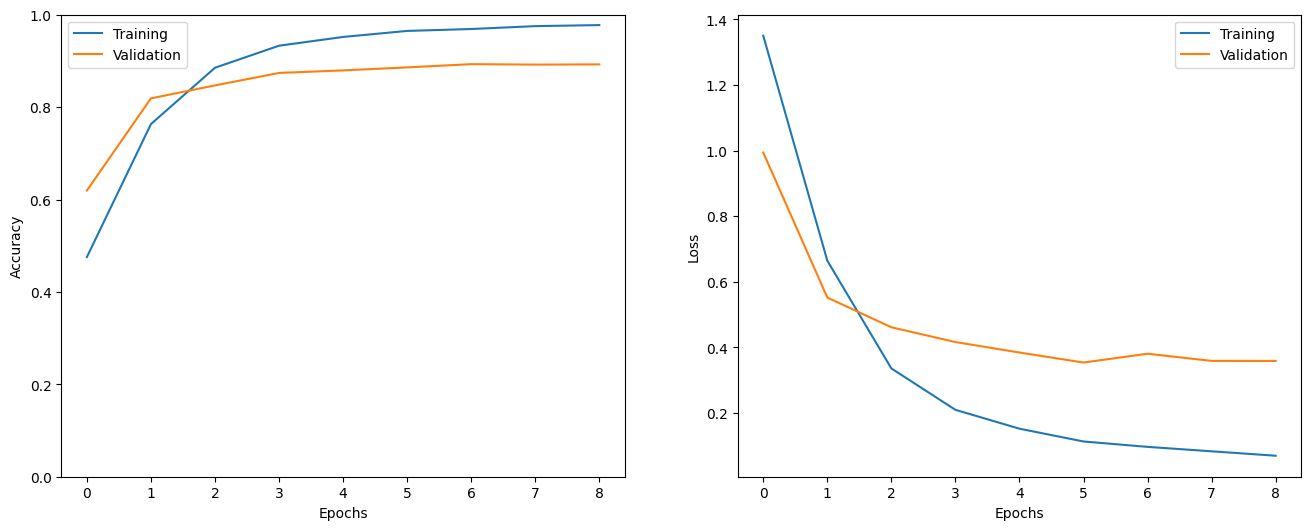

In [58]:
show_history(h)

In [59]:
test_tweets, test_labels = get_tweet(df_test)
test_seq = get_sequences(tokenizer, test_tweets)

In [60]:
_ = model.evaluate(test_seq, test_labels)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8921 - loss: 0.3955


In [75]:
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_tweets[i])
print('Emotion:', test_labels[i])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = np.argmax(p).astype(int)

print('Predicted Emotion:', pred_class)

Sentence: i feel it would be foolish and perhaps a little disrespectful to consider doing the long hilly race
Emotion: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted Emotion: 0


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


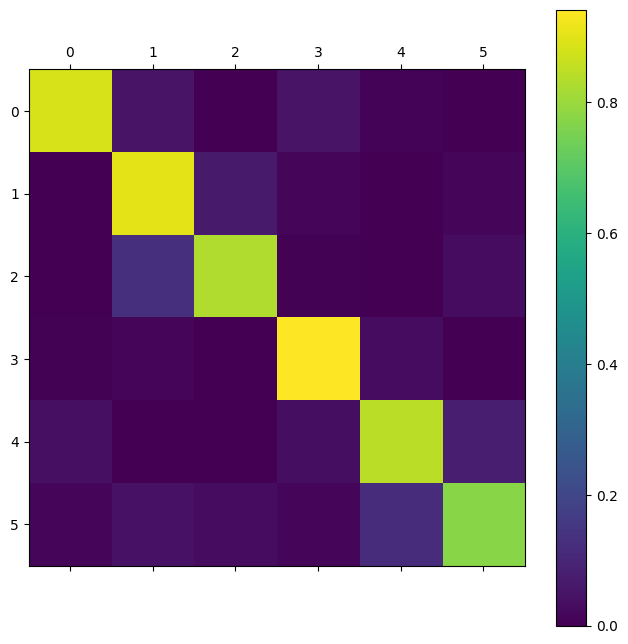

In [92]:
# confusion matrix
preds = model.predict(test_seq)
show_confusion_matrix(test_labels, preds.argmax(axis=1))


**Next Steps:**

**Hyperparameter Tuning**: Experiment with different model configurations.

**Data Augmentation**: Increase the dataset size for better performance.

**Advanced Models**: Try more complex architectures like transformers.

## Class Imbalance

# Handling Class Imbalance in Machine Learning

Class imbalance is a common challenge in machine learning, especially in classification tasks where some classes are significantly underrepresented compared to others. If not addressed, this imbalance can lead to models that perform well on majority classes but poorly on minority classes.

## Understanding Class Imbalance

Class imbalance occurs when one or more classes are represented by a significantly higher number of samples compared to other classes. This can lead to biased models that are more likely to predict the majority class, resulting in poor performance on minority classes.

For example, if a dataset contains 90% positive examples and 10% negative examples, a classifier might predict the positive class most of the time, achieving a high accuracy while performing poorly on negative examples.

The goal is to train a model that performs well on all classes, not just the majority class.

---

## Resampling Techniques

Resampling is one of the most common strategies to address class imbalance. It involves modifying the dataset by either increasing the number of minority class samples or decreasing the number of majority class samples.

### Oversampling Minority Classes

**Oversampling** involves adding more samples to the minority classes to balance the dataset. This can be done by duplicating existing samples or generating synthetic samples.

- **Random Oversampling**: Duplicates random samples from the minority class to increase their representation.

- **Synthetic Minority Over-sampling Technique (SMOTE)**: Generates synthetic samples by interpolating between existing samples of the minority class. This helps create a more diverse and realistic set of minority class samples.

The main idea of SMOTE can be expressed as:
$$ x_{new} = x_i + \lambda \times (x_j - x_i) $$
Where:
- \( x_i \) and \( x_j \) are two existing samples from the minority class.
- \( \lambda \) is a random number between 0 and 1.

### Undersampling Majority Classes

**Undersampling** reduces the number of samples from the majority class to balance the dataset. It can lead to faster training but may result in losing important data from the majority class.

- **Random Undersampling**: Randomly removes samples from the majority class to equalize the class distribution.

### Combined Approach

A combination of **oversampling the minority class** and **undersampling the majority class** can also be used to balance the dataset. Techniques like **SMOTE-Tomek** or **SMOTE-ENN** combine the advantages of both methods by removing noise and generating new samples.

---

## Using Class Weights

Another method to handle class imbalance is to assign higher weights to minority classes during model training. This makes the loss function more sensitive to errors made on minority classes, forcing the model to pay more attention to them.

In weighted loss functions, the contribution of each class to the overall loss is scaled by a weight \( w_i \) for each class \( i \). The modified loss function becomes:

$$ \text{Loss} = \sum_{i=1}^{N} w_i \cdot \text{loss}(y_i, \hat{y}_i) $$

Where:
- \( w_i \) is the weight assigned to class \( i \).
- \( y_i \) is the true label for sample \( i \).
- \( \hat{y}_i \) is the predicted label for sample \( i \).

---

## Data Augmentation

In addition to resampling, you can apply **data augmentation** techniques to artificially expand the dataset by generating new samples from the existing ones. This is particularly useful for minority classes.

For text data, augmentation can include:
- **Synonym Replacement**: Replacing words with their synonyms.
- **Back Translation**: Translating text into another language and back into the original language to create paraphrased examples.
- **Random Insertion/Swap/Delete**: Randomly modifying words within sentences to create new samples.

---

## Choosing the Right Metrics

When dealing with imbalanced data, accuracy can be misleading because it is biased towards the majority class. Instead, consider the following metrics:

- **Precision**: Measures how many of the predicted positive cases are actually positive.
  $$ \text{Precision} = \frac{TP}{TP + FP} $$

- **Recall (Sensitivity)**: Measures how many of the actual positive cases were predicted correctly.
  $$ \text{Recall} = \frac{TP}{TP + FN} $$

- **F1-Score**: The harmonic mean of precision and recall.
  $$ F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} $$

- **Confusion Matrix**: A table showing the performance of the classification algorithm in terms of True Positives (TP), False Positives (FP), True Negatives (TN), and False Negatives (FN).

---

## Algorithmic Approaches

Some algorithms are better suited for handling imbalanced data:

- **Anomaly Detection Algorithms**: Focus on identifying rare cases (useful for extreme imbalance).
  
- **Ensemble Methods**: Algorithms like **Random Forest** and **XGBoost** have techniques for handling imbalanced data. Additionally, **Balanced Random Forest** or **BalancedBaggingClassifier** apply resampling strategies within the ensemble framework.

- **Focal Loss**: A loss function that gives more weight to hard-to-classify samples and reduces the weight for well-classified samples. The formula for focal loss is:
  $$ \text{FL}(p_t) = -\alpha_t (1 - p_t)^\gamma \log(p_t) $$
  Where:
  - \( p_t \) is the predicted probability of the true class.
  - \( \alpha_t \) is a weighting factor for class imbalance.
  - \( \gamma \) is a focusing parameter to reduce the contribution of easy examples.

---

## Conclusion

Class imbalance is a critical issue in machine learning that can affect model performance. Here’s a summary of the techniques to address it:

- **Resampling Techniques**: Oversample minority classes, undersample majority classes, or use a combination.
- **Class Weights**: Assign higher weights to minority classes to penalize incorrect predictions.
- **Data Augmentation**: Create new samples for minority classes.
- **Appropriate Metrics**: Use precision, recall, F1-score, and confusion matrix instead of accuracy.
- **Algorithmic Approaches**: Use anomaly detection, ensemble methods, or focal loss to handle imbalance.

By selecting the appropriate strategy or combination of strategies, you can significantly improve the performance of your machine learning model on imbalanced datasets.


(array([4666.,    0., 5362.,    0., 1304.,    0., 2159.,    0., 1937.,
           0.,  572.]),
 array([0.        , 0.45454545, 0.90909091, 1.36363636, 1.81818182,
        2.27272727, 2.72727273, 3.18181818, 3.63636364, 4.09090909,
        4.54545455, 5.        ]),
 <BarContainer object of 11 artists>)

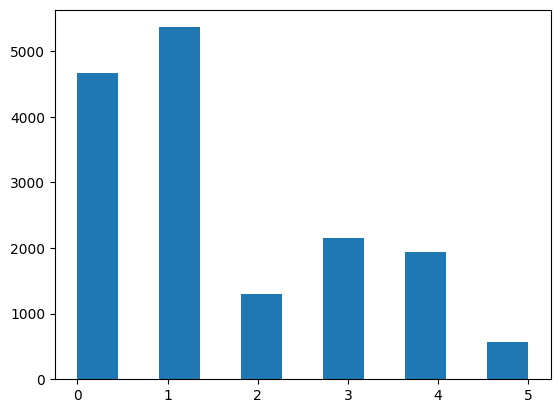

In [93]:
plt.hist(labels, bins=11)

In [94]:
from sklearn.utils.class_weight import compute_class_weight

In [96]:
# Define your model
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=16, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')    
])

model.build(input_shape=(None, maxlen))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),  # Assuming y_train contains the labels for training
    y=labels
)

class_weight_dict = dict(enumerate(class_weights))

# Train the model with class weights
history = model.fit(
    padded_train_seq, labels,                # Training data and labels
    epochs=10,                       # Number of epochs
    validation_data=(val_seq, val_labels),   # Validation data and labels
    class_weight=class_weight_dict    # Pass class weights here
)


Epoch 1/10


d:\anaconda\envs\venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.2235 - loss: 1.6918 - val_accuracy: 0.5885 - val_loss: 0.8942
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.6999 - loss: 0.6731 - val_accuracy: 0.8275 - val_loss: 0.5267
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8899 - loss: 0.3173 - val_accuracy: 0.8280 - val_loss: 0.5442
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9080 - loss: 0.2394 - val_accuracy: 0.8675 - val_loss: 0.4256
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9437 - loss: 0.1621 - val_accuracy: 0.8720 - val_loss: 0.4127
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9499 - loss: 0.1440 - val_accuracy: 0.8720 - val_loss: 0.4392
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9561 - loss: 0.1263 - val_accuracy: 0.8825 - val_loss: 0.4165
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9669 - loss: 0.0935 - val_accuracy: 0

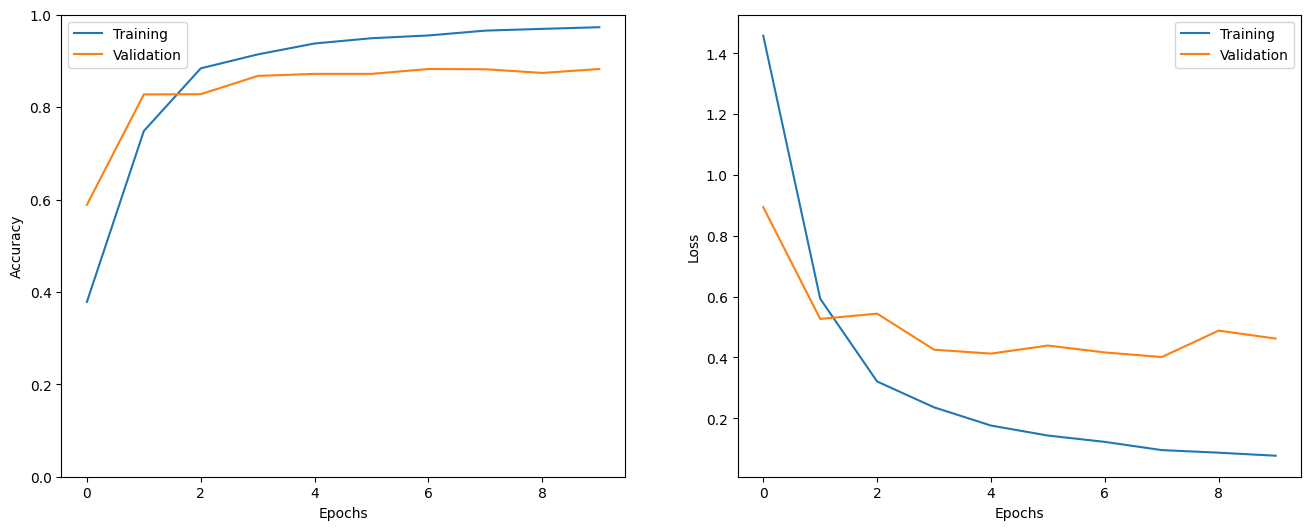

In [98]:
show_history(history)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


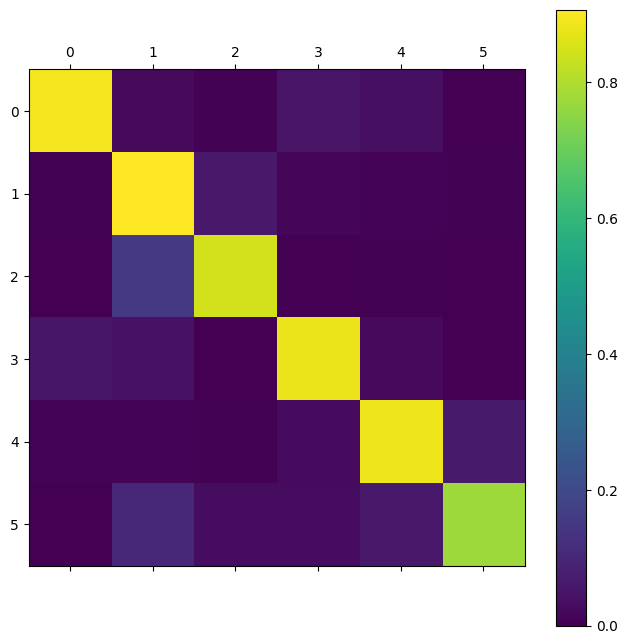

In [99]:
# confusion matrix
preds = model.predict(test_seq)
show_confusion_matrix(test_labels, preds.argmax(axis=1))